In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
import itertools
# import NOTEARS
import nt_linear as nt
from dag_generator import DAGGenerator
from sklearn.preprocessing import scale
import scipy
from matplotlib import animation
import seaborn as sns

# Attacks
This notebook contains all possible attacks on 3-node variable systems using varsortability. 

## ToC
1. Chains
    - Revert Chain
    - Introduce Fork
    - Introduce Collider
2. Forks
    - Convert Fork to Chain
    - Change Fork's origin
    - Introduce Collider
3. Colliders
    - Convert Collider into Fork
    - Convert Collider into Chain
    - Change Collider's sink node

In [3]:
SAMPLE_SIZE = 100000

## 1. Chains

### Revert Chain

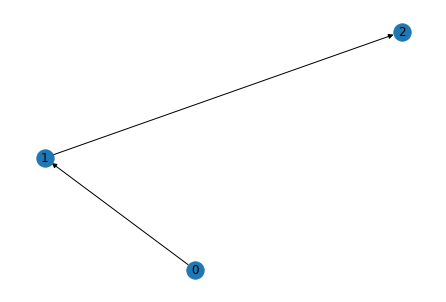

In [2]:
adj = np.array([[0, 1, 0],
                [0, 0, 1], 
                [0, 0, 0]])
G = nx.convert_matrix.from_numpy_array(adj, create_using=nx.DiGraph)
nx.draw(G, with_labels=True)

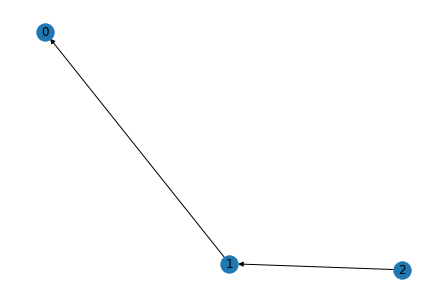

In [4]:
X_0 = np.random.normal(0, 1, SAMPLE_SIZE)
X1 = X_0 + np.random.normal(0, 1, SAMPLE_SIZE)
X2 = X1 + np.random.normal(0, 1, SAMPLE_SIZE)
gdata = np.array([X_0, X1, X2]).T
gdata = scale(gdata)

gdata[:, 0] *= 3
gdata[:, 1] *= 2

nt_pred = nt.notears_linear(gdata, 0.05, 'l2')
nt_pred_nx = nx.convert_matrix.from_numpy_array(nt_pred, create_using=nx.DiGraph)
nx.draw(nt_pred_nx, with_labels=True)

### Create Fork

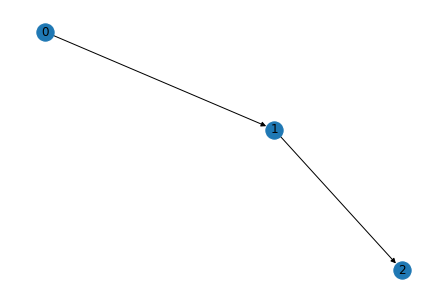

In [6]:
adj = np.array([[0, 1, 0],
                [0, 0, 1], 
                [0, 0, 0]])
G = nx.convert_matrix.from_numpy_array(adj, create_using=nx.DiGraph)
nx.draw(G, with_labels=True)

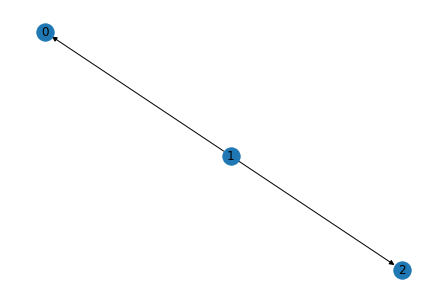

In [7]:
X_0 = np.random.normal(0, 1, SAMPLE_SIZE)
X1 = X_0 + np.random.normal(0, 1, SAMPLE_SIZE)
X2 = X1 + np.random.normal(0, 1, SAMPLE_SIZE)
gdata = np.array([X_0, X1, X2]).T
gdata = scale(gdata)

gdata[:, 2] *= 2
gdata[:, 0] *= 2

nt_pred = nt.notears_linear(gdata, 0.05, 'l2')
nt_pred_nx = nx.convert_matrix.from_numpy_array(nt_pred, create_using=nx.DiGraph)
nx.draw(nt_pred_nx, with_labels=True)

### Creating Collider

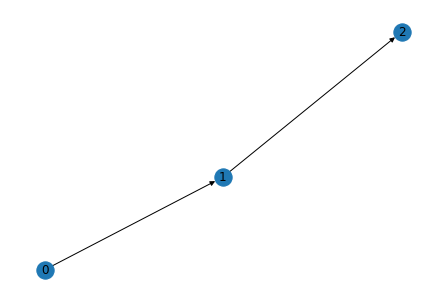

In [8]:
adj = np.array([[0, 1, 0],
                [0, 0, 1], 
                [0, 0, 0]])
G = nx.convert_matrix.from_numpy_array(adj, create_using=nx.DiGraph)
nx.draw(G, with_labels=True)

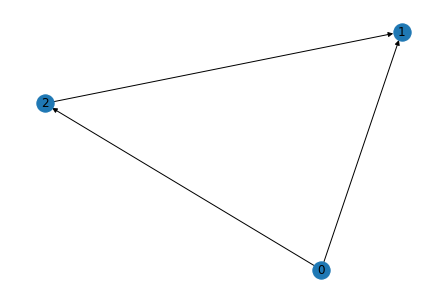

In [9]:
X_0 = np.random.normal(0, 1, SAMPLE_SIZE)
X1 = X_0 + np.random.normal(0, 1, SAMPLE_SIZE)
X2 = X1 + np.random.normal(0, 1, SAMPLE_SIZE)
gdata = np.array([X_0, X1, X2]).T
gdata = scale(gdata)

gdata[:, 1] *= 2

nt_pred = nt.notears_linear(gdata, 0.05, 'l2')
nt_pred_nx = nx.convert_matrix.from_numpy_array(nt_pred, create_using=nx.DiGraph)
nx.draw(nt_pred_nx, with_labels=True)

## 2. Forks

### Fork2Chain

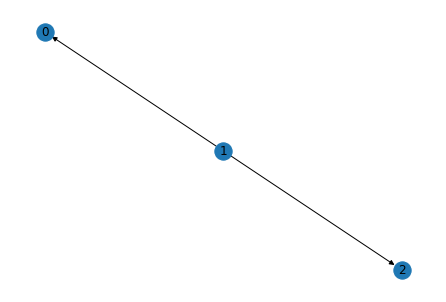

In [11]:
adj = np.array([[0, 0, 0],
                [1, 0, 1], 
                [0, 0, 0]])
G = nx.convert_matrix.from_numpy_array(adj, create_using=nx.DiGraph)
nx.draw(G, with_labels=True)

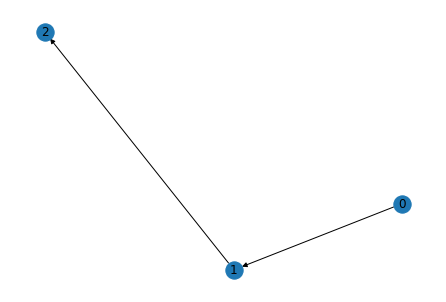

In [18]:
X1 = np.random.normal(0, 1, SAMPLE_SIZE)
X0 = X1 + np.random.normal(0, 1, SAMPLE_SIZE)
X2 = X1 + np.random.normal(0, 1, SAMPLE_SIZE)
gdata = np.array([X0, X1, X2]).T
gdata = scale(gdata)

gdata[:, 2] *= 3
gdata[:, 1] *= 2

nt_pred = nt.notears_linear(gdata, 0.05, 'l2')
nt_pred_nx = nx.convert_matrix.from_numpy_array(nt_pred, create_using=nx.DiGraph)
nx.draw(nt_pred_nx, with_labels=True)

### Change Fork origin

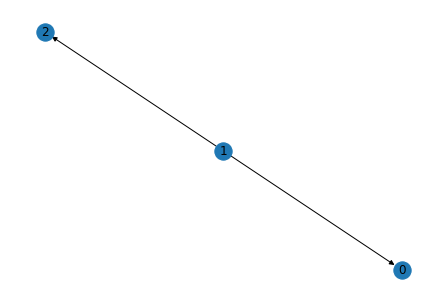

In [19]:
adj = np.array([[0, 0, 0],
                [1, 0, 1], 
                [0, 0, 0]])
G = nx.convert_matrix.from_numpy_array(adj, create_using=nx.DiGraph)
nx.draw(G, with_labels=True)

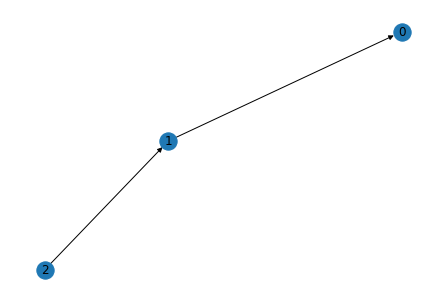

In [21]:
X1 = np.random.normal(0, 1, SAMPLE_SIZE)
X0 = X1 + np.random.normal(0, 1, SAMPLE_SIZE)
X2 = X1 + np.random.normal(0, 1, SAMPLE_SIZE)
gdata = np.array([X0, X1, X2]).T
gdata = scale(gdata)

gdata[:, 1] *= 2
gdata[:, 0] *= 2

nt_pred = nt.notears_linear(gdata, 0.05, 'l2')
nt_pred_nx = nx.convert_matrix.from_numpy_array(nt_pred, create_using=nx.DiGraph)
nx.draw(nt_pred_nx, with_labels=True)

In [24]:
def inc(a, b):
    if a < b:
        return 1
    if a == b:
        return 0.5
    else:
        return 0

In [25]:
def varsortability_step(adj, data):
    # compute demoniator
    # replace all numbers greater 0 with 1 to make computation of all existing edges/walks easier
    walk_adj = adj.copy()
    walk_adj[walk_adj != 0] = 1
    walk_number = walk_adj.sum()

    # compute sum of number of increasing marginal variances
    increasing_variances = 0
    walk_indices = np.argwhere(walk_adj == 1)
    for i, j in walk_indices:
        data_i, data_j = data[:, i], data[:, j]
        increasing_variances += inc(data_i.var(), data_j.var())
    
    return walk_number, increasing_variances

In [26]:
def varsortability(adj, data):
    # check that adj is quadratic and that data has dimensions m x n where n is the number of nodes in the graph
    assert adj.shape[0] == adj.shape[1]
    assert adj.shape[0] == data.shape[1]

    increasing_vars, walk_numbers = [], []
    # iterate from 1 to d-1
    for i in range(1, adj.shape[0]):
        mat_pow = np.linalg.matrix_power(adj, i)
        wn, iv = varsortability_step(mat_pow, data)
        increasing_vars.append(iv)
        walk_numbers.append(wn)

    return np.sum(increasing_vars) / np.sum(walk_numbers)

In [27]:
varsortability(adj, gdata)

0.0

In [23]:
gdata.var(axis=0)

array([4., 4., 1.])

### Fork2Collider

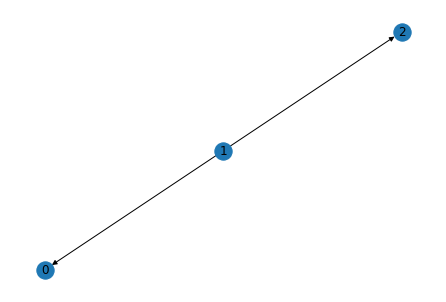

In [28]:
adj = np.array([[0, 0, 0],
                [1, 0, 1], 
                [0, 0, 0]])
G = nx.convert_matrix.from_numpy_array(adj, create_using=nx.DiGraph)
nx.draw(G, with_labels=True)

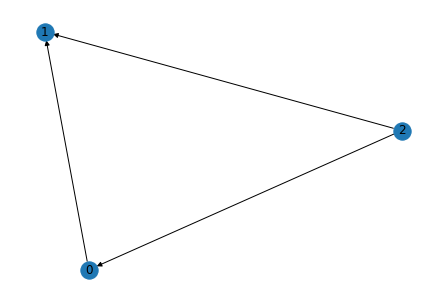

In [29]:
X1 = np.random.normal(0, 1, SAMPLE_SIZE)
X0 = X1 + np.random.normal(0, 1, SAMPLE_SIZE)
X2 = X1 + np.random.normal(0, 1, SAMPLE_SIZE)
gdata = np.array([X0, X1, X2]).T
gdata = scale(gdata)

gdata[:, 1] *= 2

nt_pred = nt.notears_linear(gdata, 0.05, 'l2')
nt_pred_nx = nx.convert_matrix.from_numpy_array(nt_pred, create_using=nx.DiGraph)
nx.draw(nt_pred_nx, with_labels=True)

## Colliders

### Collider2Chain

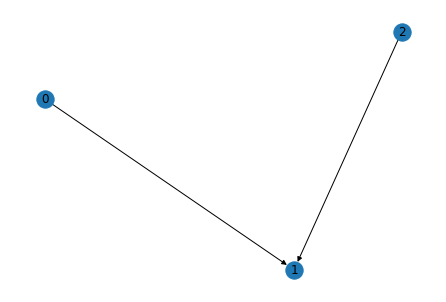

In [31]:
adj = np.array([[0, 1, 0],
                [0, 0, 0], 
                [0, 1, 0]])
G = nx.convert_matrix.from_numpy_array(adj, create_using=nx.DiGraph)
nx.draw(G, with_labels=True)

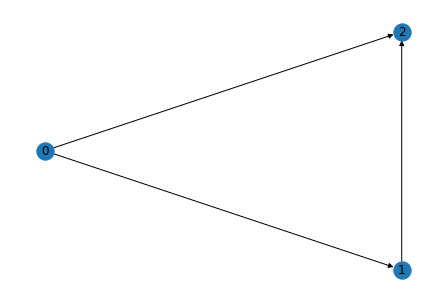

In [48]:
X0 = np.random.normal(0, 1, SAMPLE_SIZE)
X2 = np.random.normal(0, 1, SAMPLE_SIZE)
X1 = X0 + X2 + np.random.normal(0, 1, SAMPLE_SIZE)
gdata = np.array([X0, X1, X2]).T
gdata = scale(gdata)

gdata[:, 2] *= 3
gdata[:, 1] *= 2

nt_pred = nt.notears_linear(gdata, 0.05, 'l2')
nt_pred_nx = nx.convert_matrix.from_numpy_array(nt_pred, create_using=nx.DiGraph)
nx.draw_shell(nt_pred_nx, with_labels=True)

### Collider2Fork

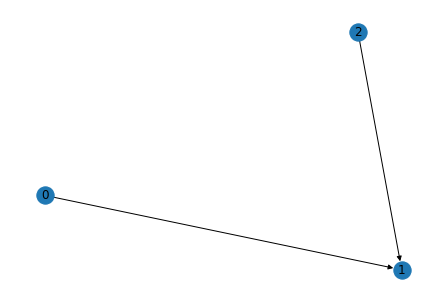

In [35]:
adj = np.array([[0, 1, 0],
                [0, 0, 0], 
                [0, 1, 0]])
G = nx.convert_matrix.from_numpy_array(adj, create_using=nx.DiGraph)
nx.draw(G, with_labels=True)

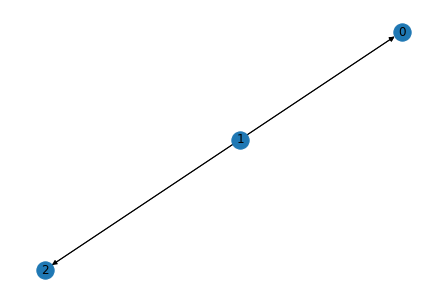

In [36]:
X0 = np.random.normal(0, 1, SAMPLE_SIZE)
X2 = np.random.normal(0, 1, SAMPLE_SIZE)
X1 = X0 + X2 + np.random.normal(0, 1, SAMPLE_SIZE)
gdata = np.array([X0, X1, X2]).T
gdata = scale(gdata)

gdata[:, 2] *= 2
gdata[:, 0] *= 2

nt_pred = nt.notears_linear(gdata, 0.05, 'l2')
nt_pred_nx = nx.convert_matrix.from_numpy_array(nt_pred, create_using=nx.DiGraph)
nx.draw(nt_pred_nx, with_labels=True)

### Change Collider sink node

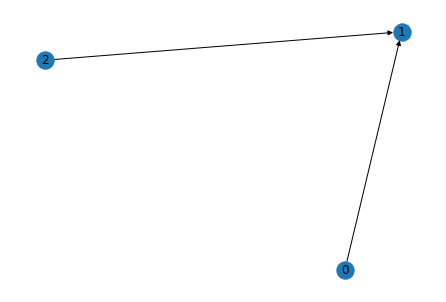

In [49]:
adj = np.array([[0, 1, 0],
                [0, 0, 0], 
                [0, 1, 0]])
G = nx.convert_matrix.from_numpy_array(adj, create_using=nx.DiGraph)
nx.draw(G, with_labels=True)

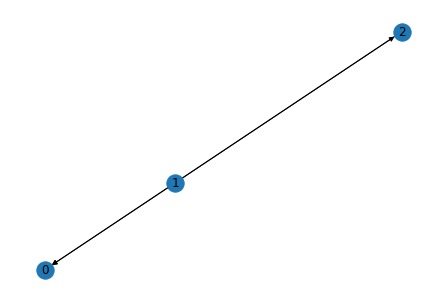

In [50]:
X0 = np.random.normal(0, 1, SAMPLE_SIZE)
X2 = np.random.normal(0, 1, SAMPLE_SIZE)
X1 = X0 + X2 + np.random.normal(0, 1, SAMPLE_SIZE)
gdata = np.array([X0, X1, X2]).T
gdata = scale(gdata)

gdata[:, 0] *= 2

nt_pred = nt.notears_linear(gdata, 0.05, 'l2')
nt_pred_nx = nx.convert_matrix.from_numpy_array(nt_pred, create_using=nx.DiGraph)
nx.draw_shell(nt_pred_nx, with_labels=True)